In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

# 1-D posterior toy example

> Demonstration of posterior error bounds for a 1-D toy example, for various levels of sensor noise

In this notebook we will demonstrate the error bounds for the statFEM posterior for the toy example introduced in <a href="/statFEM/oneDim.html#1-dimensional-case-(ODE)"><code>oneDim</code></a>. We first import some required packages.

In [ ]:
from dolfin import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,6)
from scipy.stats import multivariate_normal, linregress
from scipy import integrate
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
import sympy; sympy.init_printing()
from tqdm.notebook import tqdm
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))
# import required functions from oneDim
from statFEM.oneDim import kernMat, m_post, gen_sensor, MyExpression, m_post_fem_assembler, c_post, c_post_fem_assembler

We now set up the mean and kernel functions for the random forcing term $f$. We also set up the true prior solution mean for use with FEniCS.

In [ ]:
# set up mean and kernel functions
l_f = 0.4  # original value!!!!!!
σ_f = 0.1
#σ_f = 10.0

def m_f(x):
    return 1.0

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# mean of forcing for use in FEniCS
f_bar = Constant(1.0)

# true prior solution mean
μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)

We now set up the required funtions to compute the true prior covariance $c_u$ using the Green's function together with quadrature.

In [ ]:
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

We will also need a function `u_quad` to accurately compute the solution for a given realisation of $f$ in order to generate sensor data. This is set up below:

In [ ]:
def u_quad(x,f,maxiter=50):
    I_1 = integrate.quadrature(lambda w: w*f(w), 0.0, x,maxiter=maxiter)[0]
    I_2 = integrate.quadrature(lambda w: (1-w)*f(w),x, 1.0,maxiter=maxiter)[0]
    return (1-x)*I_1 + x*I_2

We now set up a reference grid on which we will compare the true and statFEM covariance functions. We take a grid of length $N = 41$.

In [ ]:
N = 41
grid = np.linspace(0,1,N)

We now set up the sensor grid and the true prior covariance on this sensor grid which will be needed in all further computations. We also set up the function which gives the vector $\{c_u(x,y_i)\}_{i=1}^{s}$ needed for the posterior.

In [ ]:
s = 10 # number of sensors
# create sensor grid (???do we need to reverse???)
Y = np.linspace(0.01,0.99,s)[::-1] 
# get true prior covariance on sensor grid
C_true_s = kernMat(c_u,Y.flatten())
# create function to compute vector mentioned above
def c_u_vect(x):
    return np.array([c_u(x,y_i) for y_i in Y])

We now set up a function to get the statFEM posterior for a FE mesh of size $h$, using functions from <a href="/statFEM/oneDim.html#"><code>oneDim</code></a>.

In [ ]:
# set up function to compute statFEM posterior
def fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid):
    J = int(np.round(1/h))
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ = MyExpression()
    μ.f = m_post_fem
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    return μ,Σ

We now set up a function to compare the covariance functions on the reference grid. This function computes an approximation of the covariance contribution to the 2-Wasserstein distance discussed in <a href="/statFEM/oneDim.html#Difference-between-true-prior-covariance-and-statFEM-prior-covariance"><code>oneDim</code></a>.

In [ ]:
# function to compute cov error
def compute_cov_diff(C_fem,C_true,C_true_sqrt,tol=1e-10):
    N = C_true.shape[0]
    C12 = C_true_sqrt @ C_fem @ C_true_sqrt
    C12_sqrt = np.real(sqrtm(C12))
    rel_error = np.linalg.norm(C12_sqrt @ C12_sqrt - C12)/np.linalg.norm(C12)
    assert rel_error < tol
    h = 1/(N-1)
    return h*(np.trace(C_true) + np.trace(C_fem) - 2*np.trace(C12_sqrt))

With all of this in place we can now set up a function which computes an approximation of the 2-Wasserstein distance between the true and statFEM posteriors.

In [ ]:
def W(μ_fem_s,μ_true_s,Σ_fem_s,Σ_true_s,Σ_true_s_sqrt,J_norm):
    mean_error = errornorm(μ_true_s,μ_fem_s,'L2',mesh=UnitIntervalMesh(J_norm))
    cov_error = compute_cov_diff(Σ_fem_s,Σ_true_s,Σ_true_s_sqrt)
    cov_error = np.sqrt(np.abs(cov_error))
    error = mean_error + cov_error
    return error

We now set up a range of $h$ values on which to compute this error together with a range of noise levels to use. We determine the noise levels by investigating the variances of the true prior solution at each point of the grid. We do this by plotting `c_u(x,x)` for `x` in `grid`. We also get print some summary statistics of these variances. We also#hide_input
grid_vars = np.array([c_u(x,x) for x in grid])
plt.plot(grid,grid_vars)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$\operatorname{var}(u(x))$')
plt.title('True prior variance at each grid point')
plt.show()
pd.DataFrame({'Prior Variance' : grid_vars}).describe() set up the `J_norm` variable needed to control the grid on which the mean error is computed in the Wasserstein distance.

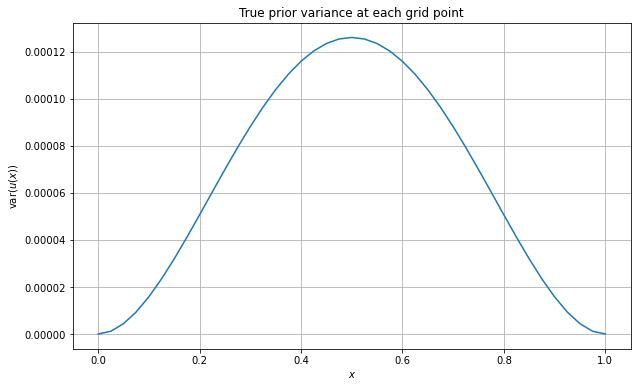

,Prior Variance
count,41.000000
mean,0.000065
std,0.000045
min,0.000000
25%,0.000023
50%,0.000070
75%,0.000110
max,0.000126


In [ ]:
#hide_input
grid_vars = np.array([c_u(x,x) for x in grid])
plt.plot(grid,grid_vars)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$\operatorname{var}(u(x))$')
plt.title('True prior variance at each grid point')
plt.show()
pd.DataFrame({'Prior Variance' : grid_vars}).describe()

In [ ]:
h_range_tmp = np.linspace(0.25,0.025,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
# print h_range to 2 decimal places
print('h values: ' + str(np.round(h_range,3))+'\n')
# noise levels to use
#ϵ_list = [0.01,0.1,0.2,0.5,1.0]
ϵ_list = [0.0001/2,0.0001,0.01,0.1]
print('ϵ values: ' + str(ϵ_list))
J_norm = 40

h values: [0.25  0.2   0.167 0.143 0.125 0.111 0.1   0.091 0.083 0.077 0.071 0.067
 0.062 0.059 0.056 0.053 0.05  0.048 0.045 0.043 0.042 0.038 0.037 0.034
 0.032 0.029 0.027 0.025]

ϵ values: [5e-05, 0.0001, 0.01, 0.1]


We now create a dictionary to hold the result for the different noise levels:

In [ ]:
results = {}

We will now loop over the list of noise levels, generate sensor data, get the statFEM posterior and true posterior and compute the error.

In [ ]:
%%time
np.random.seed(42)
tol = 1e-10 # tolerance for computation of posterior cov sqrt
for ϵ in tqdm(ϵ_list,desc='Eps loop'):
    # generate sensor data
    v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=200)
    
    # get true B mat required for posterior
    B_true = (ϵ**2)*np.eye(s) + C_true_s
    
    # set up true posterior mean
    def true_mean(x):
        return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
    μ_true_s = MyExpression()
    μ_true_s.f = true_mean
    
    # set up true posterior covariance
    def c_post_true(x,y):
        return c_post(x,y,c_u,Y,B_true)
    Σ_true_s = kernMat(c_post_true,grid.flatten())
    Σ_true_s_sqrt = np.real(sqrtm(Σ_true_s))
    rel_error = np.linalg.norm(Σ_true_s_sqrt @ Σ_true_s_sqrt - Σ_true_s) / np.linalg.norm(Σ_true_s)
    if rel_error >= tol:
        print('ERROR')
        break
    
    # loop over the h values and compute the errors 
    # first create a list to hold these errors
    res = []
    for h in tqdm(h_range,desc='h loop'):
        # get statFEM posterior mean and cov mat
        μ_fem_s, Σ_fem_s = fem_posterior(h,f_bar,k_f,ϵ,Y,v_dat,grid)
        # compute the error
        error = W(μ_fem_s,μ_true_s,Σ_fem_s,Σ_true_s,Σ_true_s_sqrt,J_norm)
        # store this in res
        res.append(error)
    
    # store ϵ value with errors in the dictionary
    results[ϵ] = res

Eps loop:   0%|          | 0/4 [00:00<?, ?it/s]

h loop:   0%|          | 0/28 [00:00<?, ?it/s]

h loop:   0%|          | 0/28 [00:00<?, ?it/s]

h loop:   0%|          | 0/28 [00:00<?, ?it/s]

h loop:   0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 15min 1s, sys: 1min 45s, total: 16min 47s
Wall time: 15min 56s


We now analyse the results by plotting the errors on a log-log scale for each noise level on the same figure. We expect a line of best fit with a slope of $p=2$. The results are shown below:

In [ ]:
#hide
log_h_range = np.log(h_range)
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)

ϵ: 0.00005,    slope: 2.0162,    intercept: -2.9227
ϵ: 0.00010,    slope: 2.0102,    intercept: -2.9486
ϵ: 0.01000,    slope: 1.9912,    intercept: -2.7739
ϵ: 0.10000,    slope: 1.9940,    intercept: -2.2309


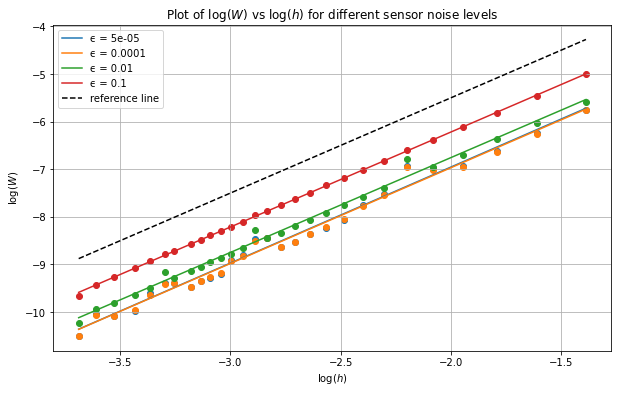

In [ ]:
#hide_input
plt.plot()
plt.grid()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
for ϵ in ϵ_list:
    errors = results[ϵ]
    log_errors = np.log(errors)
    lm = linregress(log_h_range,log_errors)
    print('ϵ: %.5f,    slope: %.4f,    intercept: %.4f' % (ϵ, lm.slope,lm.intercept))
    plt.scatter(log_h_range,log_errors)
    plt.plot(x,lm.intercept + lm.slope * x, label='ϵ = ' +str(ϵ))
plt.plot(x,-1.5+2*x,'--',c='black',label='reference line')
plt.legend()
plt.title('Plot of $\log(W)$ vs $\log(h)$ for different sensor noise levels')
plt.savefig('1D_posterior_results.png',dpi=300,bbox_inches='tight',facecolor="w")
plt.show()

From the above plot we can see that we indeed obtain slopes of arouund 2 and further that the lines for different noise levels are parallel, reflecting the different proportionality constants as different intercepts.

In [ ]:
#hide
import pickle
with open('1D_posterior_results','wb') as f:
    pickle.dump(results,f)